## COMMONVOICE DATA

In [1]:
import os
import sys
sys.path.append(os.path.abspath("../src"))  # zodat Python src als modulepad herkent
from preprocessing import normalize_text
from analysis import extract_pos_tag_scores
from analysis import load_file, compare_bleu_buckets, calculate_wer_per_sentence, get_knn_gain_outliers, wer_summary
from better_by import (
    load_pickle, classify_sentences,
    extract_pos, extract_entities, plot_distribution
)
import pandas as pd
import matplotlib.pyplot as plt 
from plotting import plot_wer_distribution, plot_knn_gain_scatter

## BLUE BUCKET ANALYSE PER SENTENCE

In [2]:
# Load data 
data_dir = "/Users/sedatgunay/Desktop/compare-mt-2/commonvoice/"
ref_path = os.path.join(data_dir, "common_test_ref_texts.txt")
knn_path = os.path.join(data_dir, "common_test_knn_texts.txt")
van_path = os.path.join(data_dir, "common_test_van_texts.txt")

# 📄 3. Laad bestanden
refs = load_file(ref_path)
knn = load_file(knn_path)
van = load_file(van_path)

# normalize texts

refs = [normalize_text(line) for line in refs]
knn  = [normalize_text(line) for line in knn]
van = [normalize_text(line) for line in van]

# ✅ Controle: gelijke lengte
assert len(refs) == len(knn) == len(van), "Lengtes van de bestanden komen niet overeen."

# 📊 4. BLEU-bucket edges instellen
bucket_edges = [10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0]

df_bleu = compare_bleu_buckets(refs, knn, van, bucket_edges)

df_bleu.style.background_gradient(cmap="RdYlGn", subset=["Verschil (sys1 - sys2)"])
# df_bleu.to_csv("bleu_buckets_commonvoice.csv", index=False)  # of een andere naam per versie

,BLEU-bucket,Aantal sys1 - kNN-MT,Aantal sys2 - Vanilla,Verschil (sys1 - sys2)
0,"[0.0,10.0)",32,35,-3
1,"[10.0,20.0)",81,67,14
2,"[20.0,30.0)",96,117,-21
3,"[30.0,40.0)",219,189,30
4,"[40.0,50.0)",281,311,-30
5,"[50.0,60.0)",496,517,-21
6,"[60.0,70.0)",519,531,-12
7,"[70.0,80.0)",1005,1044,-39
8,"[80.0,90.0)",655,664,-9
9,>=90.0,82,76,6


## POS - BUCKET ANALYSE 

In [3]:
html_path = "/Users/sedatgunay/Desktop/compare-mt-2/commonvoice/comparemt_output_commonvoice_pos/index.html"

print("POS LABEL TAGGING SCORES – COMMONVOICE")
df_commonvoice_pos = extract_pos_tag_scores(html_path)
display(df_commonvoice_pos)

POS LABEL TAGGING SCORES – COMMONVOICE


,Label,kNN-MT (sys1),Vanilla (sys2),Verschil (sys1 - sys2)
0,ADJ,0.9403,0.9374,0.0029
1,NOUN,0.9223,0.9218,0.0005
2,PROPN,0.8276,0.8300,-0.0024
3,VERB,0.9361,0.9375,-0.0014
4,ADV,0.9671,0.9635,0.0036
5,NUM,0.8166,0.6730,0.1436
6,DET,0.9770,0.9774,-0.0004
7,PRON,0.9610,0.9575,0.0035
8,ADP,0.9819,0.9791,0.0028
9,CCONJ,0.9735,0.9709,0.0026


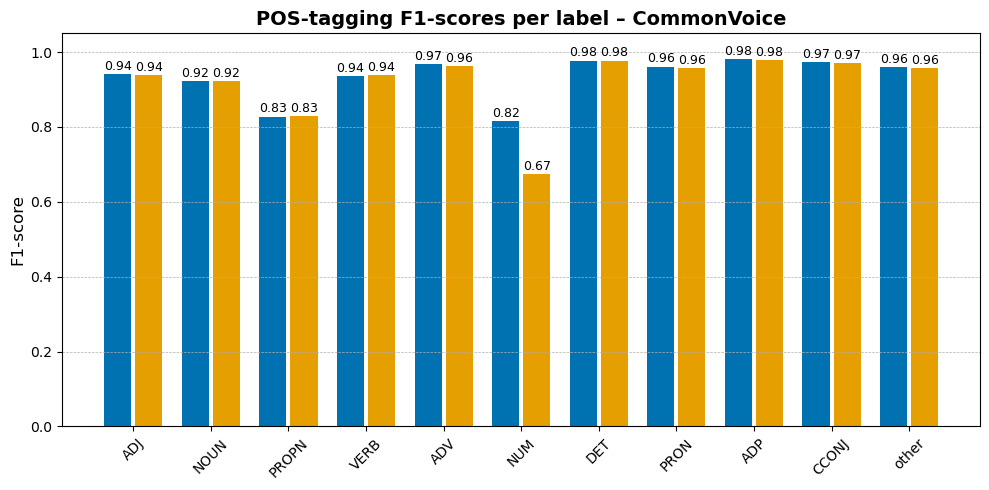

In [4]:
# import matplotlib.pyplot as plt

# fig, ax = plt.subplots(figsize=(10, 5))
# di
# labels = df_commonvoice_pos["Label"]
# x = range(len(labels))
# width = 0.35

# ax.bar(x, df_commonvoice_pos["kNN-MT (sys1)"], width, label="kNN-MT", color="green")
# ax.bar([i + width for i in x], df_commonvoice_pos["Vanilla (sys2)"], width, label="Vanilla", color="red")

# ax.set_ylabel("F1-score")
# ax.set_title("POS-tagging F1-scores per label – CommonVoice")
# ax.set_xticks([i + width / 2 for i in x])
# ax.set_xticklabels(labels, rotation=45)
# ax.legend()
# ax.grid(axis="y")
# plt.tight_layout()
# plt.savefig("pos_f1_commonvoice.png", dpi=300, bbox_inches="tight")
# plt.show()



fig, ax = plt.subplots(figsize=(10, 5))

# Kleurenblindvriendelijke kleuren
colors = ["#0072B2", "#E69F00"]  # blauw, oranje
labels = df_commonvoice_pos["Label"]
x = range(len(labels))
width = 0.35
gap = 0.05  # extra afstand tussen knn en vanilla

# Balken
bars1 = ax.bar([i - gap/2 for i in x], df_commonvoice_pos["kNN-MT (sys1)"], width, label="kNN-MT", color=colors[0])
bars2 = ax.bar([i + width + gap/2 for i in x], df_commonvoice_pos["Vanilla (sys2)"], width, label="Vanilla", color=colors[1])

# Labels boven de balken
for bar in bars1 + bars2:
    height = bar.get_height()
    ax.annotate(f"{height:.2f}", xy=(bar.get_x() + bar.get_width()/2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', fontsize=9)

# Aslabels en opmaak
ax.set_ylabel("F1-score", fontsize=12)
ax.set_title("POS-tagging F1-scores per label – CommonVoice", fontsize=14, fontweight='bold')
ax.set_xticks([i + width / 2 for i in x])
ax.set_xticklabels(labels, rotation=45, fontsize=10)
ax.set_ylim(0, 1.05)
ax.tick_params(axis='y', labelsize=10)
ax.grid(axis="y", linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.savefig("pos_f1_commonvoice.png", dpi=300, bbox_inches="tight")
plt.show()

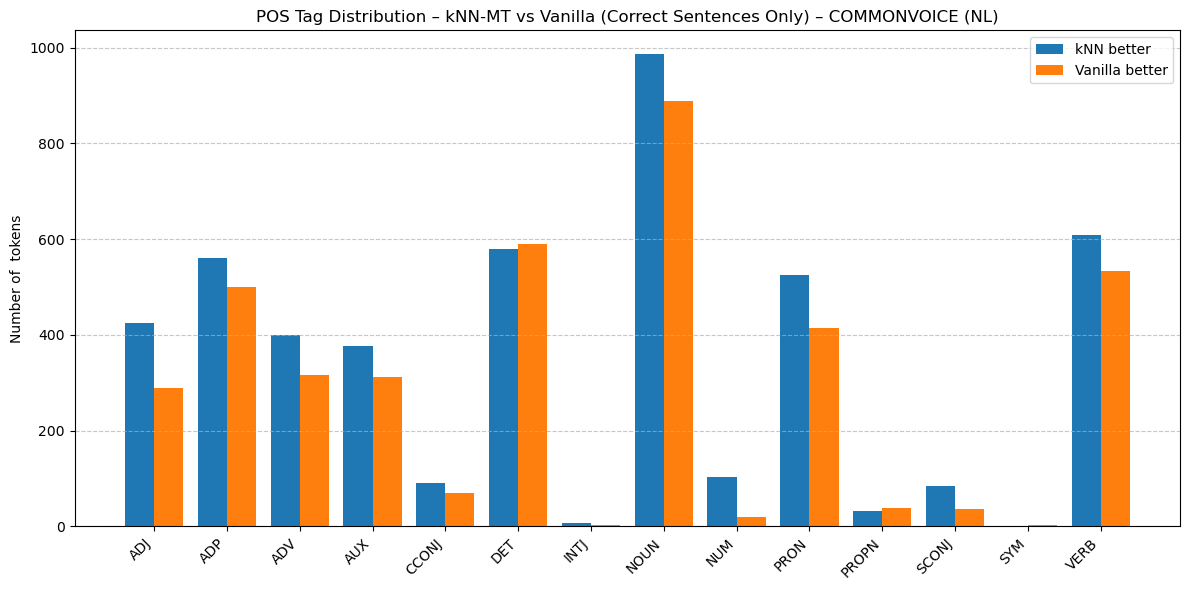

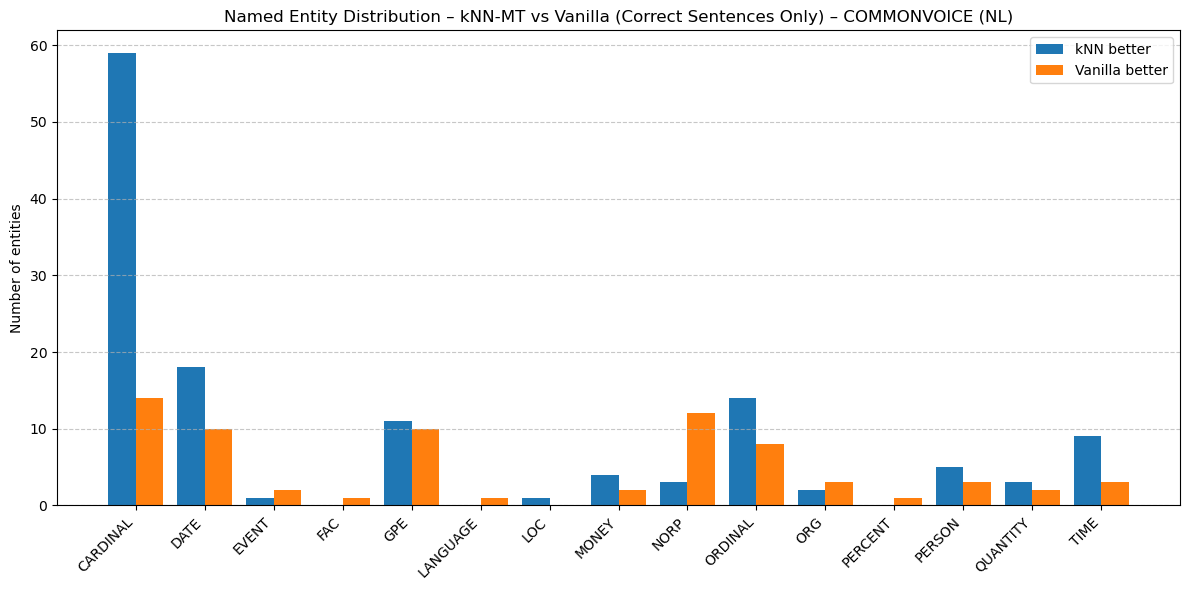

In [5]:
base_path = "/Users/sedatgunay/Desktop/ASR_KNN/dataset data (+outputs)/commonvoice"
lang = "nl"  

# Load data
ref = load_pickle(os.path.join(base_path, "test_ref_texts.pkl"))
knn = load_pickle(os.path.join(base_path, "test_knn_texts.pkl"))
van = load_pickle(os.path.join(base_path, "test_van_texts.pkl"))


ref = [normalize_text(line) for line in ref]
knn  = [normalize_text(line) for line in knn]
van = [normalize_text(line) for line in van]

# Sort better by sentences on systems 
better_knn, better_van = classify_sentences(ref, knn, van)

# POS-tag analysis
pos_knn = extract_pos(better_knn, lang=lang)
pos_van = extract_pos(better_van, lang=lang)
all_pos = sorted(set(pos_knn.keys()).union(pos_van.keys()))

plot_distribution(
    all_pos,
    [pos_knn.get(p, 0) for p in all_pos],
    [pos_van.get(p, 0) for p in all_pos],
    title=f"POS Tag Distribution – kNN-MT vs Vanilla (Correct Sentences Only) – COMMONVOICE ({lang.upper()})",
    ylabel="Number of  tokens"
)

# Entity-analyse
ent_knn = extract_entities(better_knn, lang=lang)
ent_van = extract_entities(better_van, lang=lang)
all_ents = sorted(set(ent_knn.keys()).union(ent_van.keys()))

plot_distribution(
    all_ents,
    [ent_knn.get(e, 0) for e in all_ents],
    [ent_van.get(e, 0) for e in all_ents],
    title=f"Named Entity Distribution – kNN-MT vs Vanilla (Correct Sentences Only) – COMMONVOICE ({lang.upper()})",
    ylabel="Number of entities"
)



### WER ANALYSE

In [6]:
# wer analyses
wer_knn = calculate_wer_per_sentence(ref,knn)
wer_van = calculate_wer_per_sentence(ref,van)

# print means 
print("Mean WER (kNN):", wer_summary(ref,knn)["wer"])
print("Mean WER (van):", wer_summary(ref,van)["wer"])


# Vind zinnen waar kNN significant beter was
gain_outliers = get_knn_gain_outliers(ref, knn, van, threshold=0.5)
gain_indices = [entry[0] for entry in gain_outliers]

# gain_outliers

Mean WER (kNN): 0.05343407792510112
Mean WER (van): 0.05540305919553051


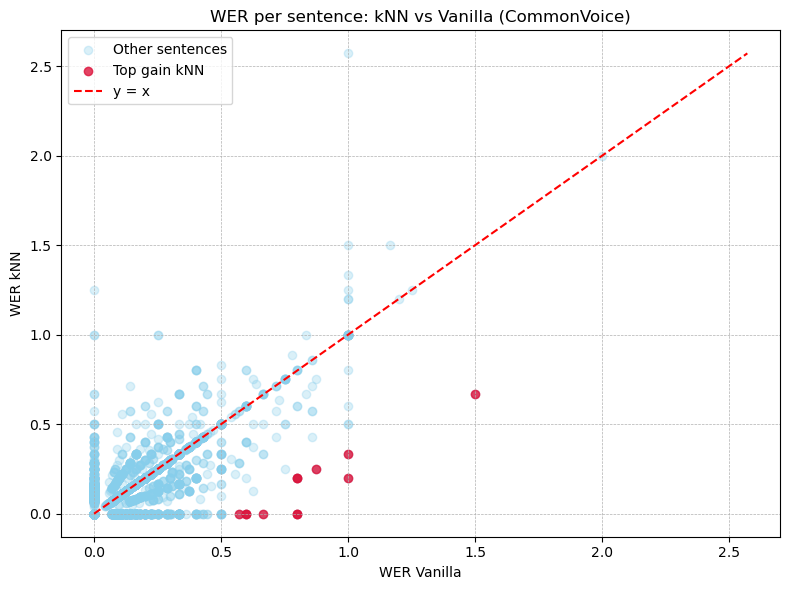

In [7]:
plot_knn_gain_scatter(wer_knn, wer_van,
    gain_indices,
    domain_label="CommonVoice"
)

In [8]:
import pandas as pd

df_gain = pd.DataFrame(gain_outliers, columns=[
    "Index", "ref", "vanilla", "knn", "wer_vanilla", "wer_knn", "wer_gain_knn"
])

# Sorteer op grootste winst, optioneel
df_gain = df_gain.sort_values(by="wer_gain_knn", ascending=False).reset_index(drop=True)

# Bekijk de eerste rijen
display(df_gain)  


,Index,ref,vanilla,knn,wer_vanilla,wer_knn,wer_gain_knn
0,1408,ze wou weer de heldin uithangen.,het is heel raar waar je nu heen bent.,zij waren weer de helderdom.,1.500000,0.666667,0.833333
1,615,als dessert krijgen we tiramisu.,als de zee krijg ik een tiramisu.,als dossier krijgen we tiramisu.,1.000000,0.200000,0.800000
2,3227,drie maal negen is zevenentwintig.,3 x 9 is 27.,drie maal negen is zevenentwintig.,0.800000,0.000000,0.800000
3,8531,u hebt hierover niets gezegd.,we hebben je over niets gezegd.,u hebt hierover niets gezegd.,0.800000,0.000000,0.800000
4,3426,frietjes maak je in een friteuse.,"fritsjes, maagje en fritoso.","frities, maak je in een frité.",1.000000,0.333333,0.666667
5,10498,er bespottelijk uitzien.,er bespotten lijkt uitzien.,er bespottelijk uitzien.,0.666667,0.000000,0.666667
6,3862,ik had een buis voor het vak geschiedenis.,"ik kan hem buigen, omdat het vaak geschieden is.",ik kan een baas voor het vak geschiedenis.,0.875000,0.250000,0.625000
7,1137,acht min vijf is drie.,8-5 is 3.,8 min vijf is drie.,0.800000,0.200000,0.600000
8,7758,er zijn veel diepgewortelde verschillen.,er zijn veel diep geworden door de verschillen.,er zijn veel diepgeworden verschillen.,0.800000,0.200000,0.600000
9,3817,zes keer twee is twaalf.,6 keer 2 is 12.,zes keer twee is twaalf.,0.600000,0.000000,0.600000


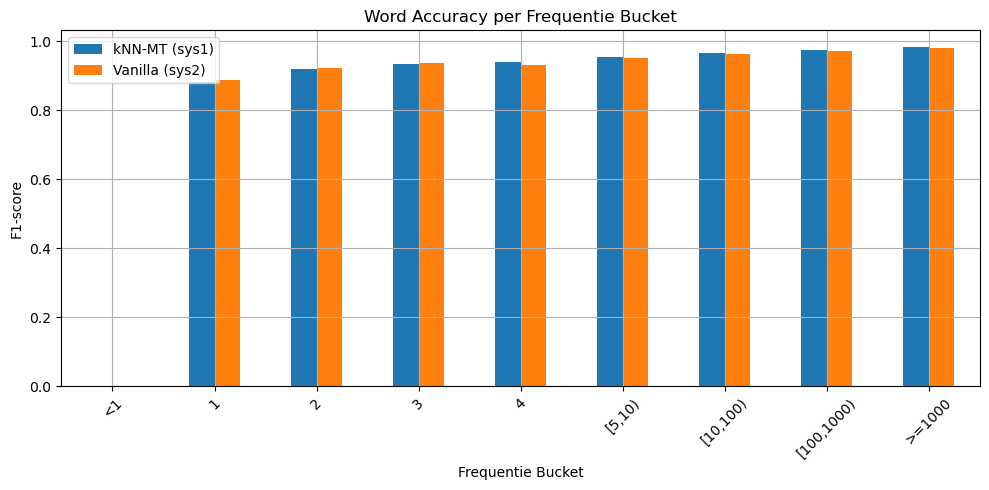

,Frequentie Bucket,kNN-MT (sys1),Vanilla (sys2),Verschil (sys1 - sys2)
0,<1,0.0000,0.0000,0.0000
1,1,0.8820,0.8881,-0.0061
2,2,0.9216,0.9236,-0.0020
3,3,0.9360,0.9367,-0.0007
4,4,0.9416,0.9330,0.0086
5,"[5,10)",0.9547,0.9509,0.0038
6,"[10,100)",0.9678,0.9644,0.0034
7,"[100,1000)",0.9756,0.9733,0.0023
8,>=1000,0.9832,0.9823,0.0009


In [9]:
from analysis import extract_freq_bucket_scores
html_path = "/Users/sedatgunay/Desktop/compare-mt-2/commonvoice/comparemt_output_freq/index.html"

df_commonvoice_pos_TEST = extract_freq_bucket_scores(html_path)
display(df_commonvoice_pos_TEST)

In [10]:
def save_wer_scores(ref_path, hyp_path, out_path, normalize=True):
    """
    Bereken per-zin WER en sla op in een bestand. Optioneel met normalisatie.

    Parameters:
        ref_path (str): pad naar referentiebestand (.txt)
        hyp_path (str): pad naar hypothesebestand (.txt)
        out_path (str): pad naar outputbestand voor WER-scores
        normalize (bool): of normalisatie toegepast moet worden (default = True)
    """
    # Lees inputbestanden
    with open(ref_path, "r", encoding="utf-8") as f:
        refs = [line.strip() for line in f if line.strip()]
    with open(hyp_path, "r", encoding="utf-8") as f:
        hyps = [line.strip() for line in f if line.strip()]

    # Check lengte
    assert len(refs) == len(hyps), "Mismatch in aantal regels tussen ref en hyp"

    # Optioneel: normaliseer
    if normalize:
        refs = [normalize_text(line) for line in refs]
        hyps = [normalize_text(line) for line in hyps]

    # Bereken per-zin WER
    results = calculate_wer_per_sentence(refs, hyps)
    wers = [r["wer"] * 100 for r in results]  # schaal naar 0–100%

    # Schrijf naar bestand
    with open(out_path, "w", encoding="utf-8") as f:
        for w in wers:
            f.write(f"{w:.2f}\n")

    print(f"[✓] WER-scores opgeslagen in {out_path}")

In [11]:
#save wer vanilla
save_wer_scores(
    ref_path= ref_path,
    hyp_path=van_path,
    out_path="results/wer_scores_van_com.txt",
    normalize=True
)



[✓] WER-scores opgeslagen in results/wer_scores_van_com.txt


In [12]:
#save wer knn
save_wer_scores(
    ref_path= ref_path,
    hyp_path=knn_path,
    out_path="results/wer_scores_knn_com.txt",
    normalize=True
)

[✓] WER-scores opgeslagen in results/wer_scores_knn_com.txt


In [26]:
from bs4 import BeautifulSoup
import pandas as pd

def extract_frequency_buckets_from_html(html_path):
    """
    Extract frequency bucket results from a Compare-MT HTML file as a DataFrame.

    Parameters:
    - html_path (str): Path to the `index.html` file generated by Compare-MT

    Returns:
    - pd.DataFrame: DataFrame with columns [Bucket, kNN-MT, Vanilla]
    """
    with open(html_path, "r", encoding="utf-8") as f:
        soup = BeautifulSoup(f, "html.parser")

    # Zoek juiste tabel
    freq_table = None
    for table in soup.find_all("table"):
        caption = table.find("caption")
        if caption and "word fmeas by frequency bucket" in caption.text.lower():
            freq_table = table
            break

    if freq_table is None:
        raise ValueError("Frequentie-bucket tabel niet gevonden in HTML-bestand.")

    # Parse rijen
    rows = freq_table.find_all("tr")[1:]  # skip header
    data = []

    for row in rows:
        cols = row.find_all("td")
        if len(cols) < 3:
            continue  # sla lege of foutieve rijen over
        try:
            bucket = row.find("th").text.strip()
            knn = float(cols[0].text.strip())
            van = float(cols[1].text.strip())
        except ValueError:
            continue  # sla rijen met niet-numerieke scores over (zoals 'Examples')
        data.append((bucket, knn, van))

    return pd.DataFrame(data, columns=["Bucket", "kNN-MT", "Vanilla"])

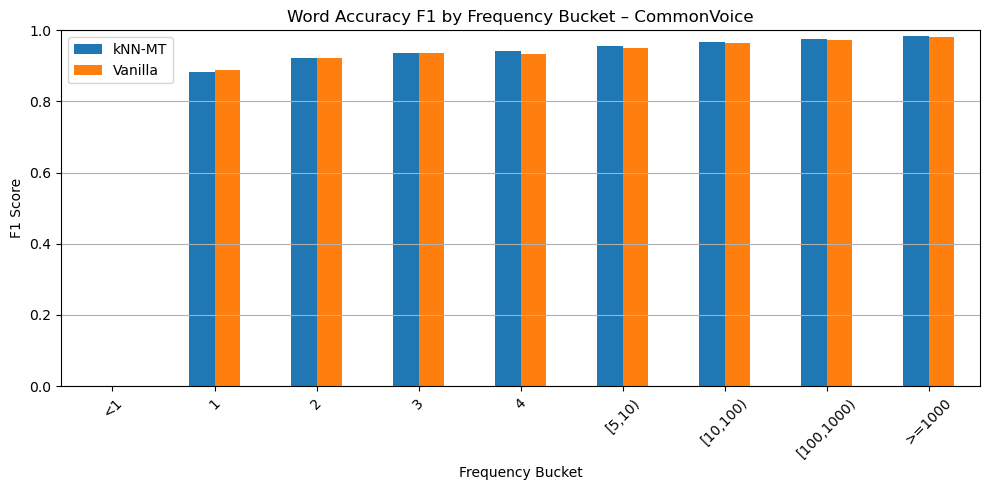

In [27]:
path = "/Users/sedatgunay/Desktop/compare-mt-2/commonvoice/comparemt_output_freq/index.html"
plot_frequency_buckets_from_html(path, domain_name="CommonVoice")

In [28]:
df_freq = extract_frequency_buckets_from_html(path)
print(df_freq)

       Bucket  kNN-MT  Vanilla
0          <1  0.0000   0.0000
1           1  0.8820   0.8881
2           2  0.9216   0.9236
3           3  0.9360   0.9367
4           4  0.9416   0.9330
5      [5,10)  0.9547   0.9509
6    [10,100)  0.9678   0.9644
7  [100,1000)  0.9756   0.9733
8      >=1000  0.9832   0.9823


In [29]:
path_libri = "/Users/sedatgunay/Desktop/compare-mt-2/librispeech/comparemt_output_freq/index.html"
df_freq_libri = extract_frequency_buckets_from_html(path_libri)
print(df_freq_libri)

       Bucket  kNN-MT  Vanilla
0          <1  0.0000   0.0000
1           1  0.9245   0.9205
2           2  0.9429   0.9416
3           3  0.9455   0.9406
4           4  0.9522   0.9489
5      [5,10)  0.9591   0.9547
6    [10,100)  0.9701   0.9653
7  [100,1000)  0.9833   0.9826
8      >=1000  0.9827   0.9826


In [30]:
path_vox = "/Users/sedatgunay/Desktop/compare-mt-2/voxpopuli/comparemt_output_freq/index.html"
df_freq_vox = extract_frequency_buckets_from_html(path_vox)
print(df_freq_vox)

       Bucket  kNN-MT  Vanilla
0          <1  0.0000   0.0000
1           1  0.8414   0.8203
2           2  0.8690   0.8505
3           3  0.8808   0.8598
4           4  0.8889   0.8640
5      [5,10)  0.8885   0.8583
6    [10,100)  0.9020   0.8817
7  [100,1000)  0.9261   0.9157
8      >=1000  0.9445   0.9383


In [32]:
path_num = "/Users/sedatgunay/Desktop/num/commonvoice/comparemt_output_freq_num/index.html"
df_freq_num = extract_frequency_buckets_from_html(path_num)
print(df_freq_num)

       Bucket  kNN-MT  Vanilla
0          <1  0.0000   0.0000
1           1  0.5400   0.8881
2           2  0.6091   0.9236
3           3  0.6478   0.9367
4           4  0.6690   0.9330
5      [5,10)  0.6689   0.9509
6    [10,100)  0.7572   0.9644
7  [100,1000)  0.7883   0.9733
8      >=1000  0.8600   0.9823
